In [2]:
# code
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import Input, Model
from keras.layers import Layer, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
import matplotlib.pyplot as plt

In [2]:
# this sampling layer is the bottleneck layer of variational autoencoder,
# it uses the output from two dense layers z_mean and z_log_var as input,
# convert them into normal distribution and pass them to the decoder layer
class Sampling(Layer):

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape =(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
# Define Encoder Model
latent_dim = 2

encoder_inputs = Input(shape =(28, 28, 1))
x = Conv2D(32, 3, activation ="relu", strides = 2, padding ="same")(encoder_inputs)
x = Conv2D(64, 3, activation ="relu", strides = 2, padding ="same")(x)
x = Flatten()(x)
x = Dense(16, activation ="relu")(x)
z_mean = Dense(latent_dim, name ="z_mean")(x)
z_log_var = Dense(latent_dim, name ="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name ="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 14, 14, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 3136)         0           ['conv2d_1[0][0]']               
                                                                                            

In [4]:
# Define Decoder Architecture
latent_inputs = keras.Input(shape =(latent_dim, ))
x = Dense(7 * 7 * 64, activation ="relu")(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(64, 3, activation ="relu", strides = 2, padding ="same")(x)
x = Conv2DTranspose(32, 3, activation ="relu", strides = 2, padding ="same")(x)
decoder_outputs = Conv2DTranspose(1, 3, activation ="sigmoid", padding ="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name ="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

In [5]:
# this class takes encoder and decoder models and
# define the complete variational autoencoder architecture
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [ ]:
# load fashion mnist dataset  from  keras.dataset API
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()
fmnist_images = np.concatenate([x_train, x_test], axis = 0)
# expand dimension to add  a color map dimension
fmnist_images = np.expand_dims(fmnist_images, -1).astype("float32") / 255

# compile and train the model
vae = VAE(encoder, decoder)
vae.compile(optimizer ='rmsprop')
vae.fit(fmnist_images, epochs = 100, batch_size = 64)

4422102/4422102 [==============================] - 1s 0us/step
Epoch 1/100
1094/1094 [==============================] - 127s 103ms/step - loss: 297.7255 - reconstruction_loss: 294.2793 - kl_loss: 3.4462
Epoch 2/100
1094/1094 [==============================] - 104s 95ms/step - loss: 271.9351 - reconstruction_loss: 268.4373 - kl_loss: 3.4979
Epoch 3/100
1094/1094 [==============================] - 108s 99ms/step - loss: 267.4338 - reconstruction_loss: 263.9875 - kl_loss: 3.4462
Epoch 4/100
1094/1094 [==============================] - 104s 95ms/step - loss: 264.8807 - reconstruction_loss: 261.4348 - kl_loss: 3.4459
Epoch 5/100
1094/1094 [==============================] - 112s 103ms/step - loss: 263.2272 - reconstruction_loss: 259.7637 - kl_loss: 3.4635
Epoch 6/100
1094/1094 [==============================] - 121s 111ms/step - loss: 261.9164 - reconstruction_loss: 258.4321 - kl_loss: 3.4843
Epoch 7/100
1094/1094 [==============================] - 118s 108ms/step - loss: 260.8774 - reconstr

In [ ]:
def plot_latent(encoder, decoder):
    # display a n * n 2D manifold of images
    n = 10
    img_dim = 28
    scale = 2.0
    figsize = 15
    figure = np.zeros((img_dim * n, img_dim * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of images classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            images = x_decoded[0].reshape(img_dim, img_dim)
            figure[
                i * img_dim : (i + 1) * img_dim,
                j * img_dim : (j + 1) * img_dim,
            ] = images

    plt.figure(figsize =(figsize, figsize))
    start_range = img_dim // 2
    end_range = n * img_dim + start_range + 1
    pixel_range = np.arange(start_range, end_range, img_dim)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap ="Greys_r")
    plt.show()


plot_latent(encoder, decoder)

In [ ]:
def plot_label_clusters(encoder, decoder, data, test_lab):
    z_mean, _, _ = encoder.predict(data)
    plt.figure(figsize =(12, 10))
    sc = plt.scatter(z_mean[:, 0], z_mean[:, 1], c = test_lab)
    cbar = plt.colorbar(sc, ticks = range(10))
    cbar.ax.set_yticklabels([labels.get(i) for i in range(10)])
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


labels = {0    :"T-shirt / top",
1:    "Trouser",
2:    "Pullover",
3:    "Dress",
4:    "Coat",
5:    "Sandal",
6:    "Shirt",
7:    "Sneaker",
8:    "Bag",
9:    "Ankle boot"}

(x_train, y_train), _ = keras.datasets.fashion_mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255
plot_label_clusters(encoder, decoder, x_train, y_train)

In [6]:
# iPython specific stuff
%matplotlib inline
import IPython.display
from ipywidgets import interact, interactive, fixed

# Packages we're using
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    window_size, window_step = map(int, (window_size, window_step))
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((nw,ws),dtype = a.dtype)

    for i in range(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start : stop]

    return out


def stft(X, fftsize=128, step=65, mean_normalize=True, real=False,
         compute_onesided=True):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)

    size = fftsize
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X

def pretty_spectrogram(d,log = True, thresh= 5, fft_size = 512, step_size = 64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(stft(d, fftsize=fft_size, step=step_size, real=False,
        compute_onesided=True))

    if log == True:
        specgram /= specgram.max() # volume normalize to max 1
        specgram = np.log10(specgram) # take log
        specgram[specgram < -thresh] = -thresh # set anything less than the threshold as the threshold
    else:
        specgram[specgram < thresh] = thresh # set anything less than the threshold as the threshold

    return specgram

In [4]:
### Parameters ###
fft_size = 512 # window size for the FFT
step_size = fft_size/16 # distance to slide along the window (in time)
spec_thresh = 10 # threshold for spectrograms (lower filters out more noise)
lowcut = 500 # Hz # Low cut for our butter bandpass filter
highcut = 15000 # Hz # High cut for our butter bandpass filter
# For mels
n_mel_freq_components = 64 # number of mel frequency channels
shorten_factor = 10 # how much should we compress the x-axis (time)
start_freq = 300 # Hz # What frequency to start sampling our melS from
end_freq = 8000 # Hz # What frequency to stop sampling our melS from

Text(0.5, 1.0, 'Original Spectrogram')

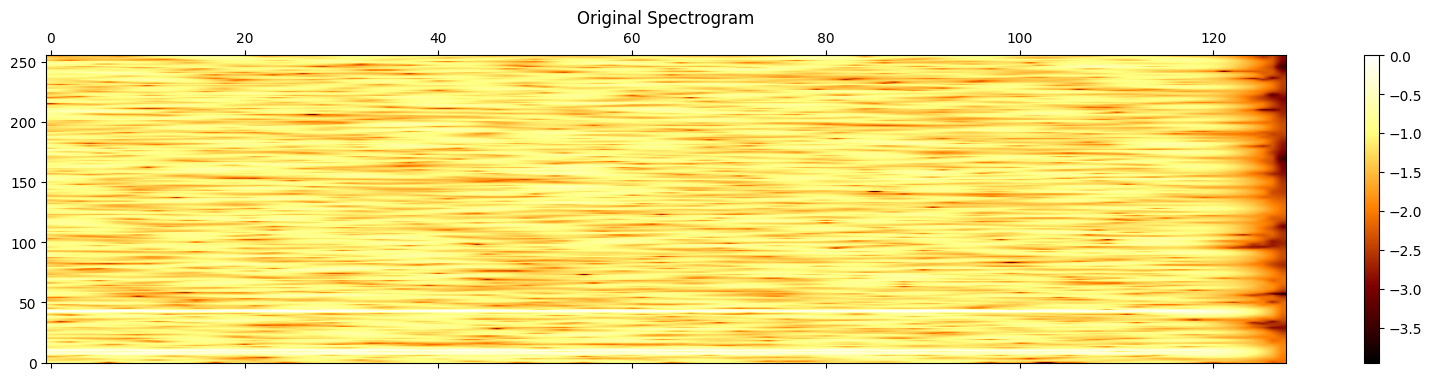

In [12]:
train = pd.read_csv('train.csv', header=None).to_numpy()

s = train[100, :]

X = pretty_spectrogram(s.astype('float64'), fft_size = fft_size, step_size = step_size, log = True, thresh = spec_thresh)

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
cax = ax.matshow(np.transpose(X), interpolation='bilinear', aspect='auto', cmap=plt.cm.afmhot, origin='lower')
fig.colorbar(cax)
plt.title('Original Spectrogram')